In [1]:
from cbayes import sample
from cbayes import distributions
from cbayes import solve
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
import scipy.stats as sstats
import ipywidgets as wid

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['font.size'] = 18

In [4]:
##### FIXED PARAMETERS - DEFINE YOUR EXPERIMENT #####
num_observations = 50 # how many observations are you able to make?
start_time = 1
end_time = 5
####

def makemodel(t):
    num_obs = len(t)
    def model(lam = None):
        if lam is None: 
            lam = np.zeros(num_obs+1).reshape(1,-1)
            lam[:,0] = 0.25
        QoI = lam[:,0].reshape(-1,1)*np.exp(-0.5*t) - lam[:,1::]
        if QoI.shape[0] == 1:
            return QoI.reshape(1,-1) # this allows support for simpler 1D plotting.
        else:
            return QoI
    return model


t = np.linspace(start_time, end_time, num_observations)
ed_model = makemodel(t)
u = ed_model()

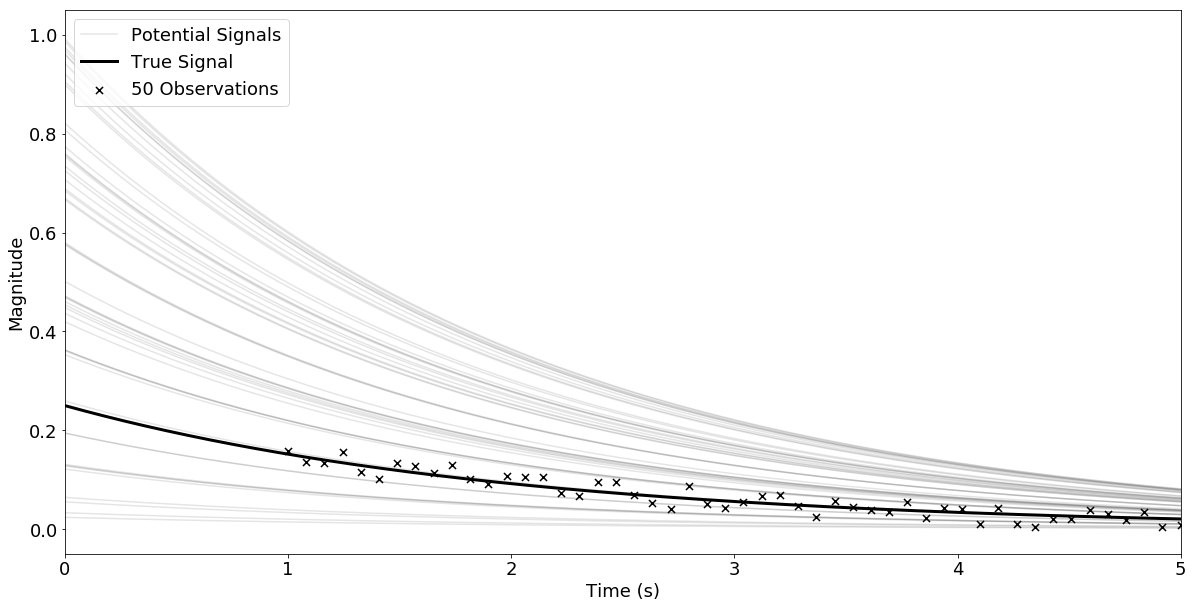

In [5]:
n = 50

sd_test_n = 5E-2
# sd_test_u = 0.05
lam = np.random.random(size=(1,1+num_observations))
lam[:,1::] *= sd_test_n
lam[:,1::] -= sd_test_n/2
lam[:,0] = 0.25
# lam[:,1]*= 0.25*0

mintime = 0
maxtime = 5
ns = 500 # fine-scaled plotting
tt = np.linspace(mintime, maxtime, ns)

m = makemodel(tt)
lamf = np.random.random(size=(n,1+ns))
lamf[:,1::] *= 0
ui = m(lamf)

um = m()

plt.figure(figsize=(20,10))
plt.cla()
show_obs = True
# Plotting the default IR results from the epidemic_IR function.
for i in range(n):
    d = ui[i,:]
    if i == n-1:
        plt.plot(tt, d, c='k', alpha=5/n, label='Potential Signals')
    else:
        plt.plot(tt, d, c='k', alpha=5/n) # I


plt.plot(tt, um.ravel(), c='k', lw=3, ls='-', label='True Signal')
if show_obs:
    plt.scatter(t, ed_model(lam), marker='x', s=50, c='k', label='{} Observations'.format(num_observations), alpha=1)

plt.legend(fontsize=18,loc='upper left')
plt.ylabel('Magnitude', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)
plt.ylim([-.05,1.05])
plt.xlim([0,5])

# ftype = 'png'
# if show_obs:
#     summary_save_str = "saveimgs/HO/HO_%d_r-%d_obs-%de-3_sd-t_%d_%d_st%d_%d.%s"%(n, num_observations, 1000*sd_test_n, mintime, maxtime, start_time, end_time, ftype)
# else:
#     summary_save_str = "saveimgs/HO/HO_signal-%d_t_%d_%d_st%d_%d.%s"%(n, mintime, maxtime, start_time, end_time, ftype)

# print("saving " + summary_save_str)
# plt.savefig(summary_save_str)
plt.show()

In [6]:
data_std = 5E-2
prior_std = 0.25

# data_std = 0.1
# prior_std = 0.25

N = 10000
M = num_observations
model = ed_model


lam = 0.25
lam_true = np.zeros(M+1).reshape(1,-1) # zero noise
lam_true[:,0] = lam
obs_data = model(lam_true).ravel() # here "observed data" is noiseless because of the way the model is defined with the noise as part of the input parameter space.
def loss_fun(output_samples):
    return (1./data_std)*(1./np.sqrt(M))*np.sum( output_samples - obs_data, axis=1)

np.random.seed(1865) #7146
noise = 0*np.random.randn(num_observations)*data_std # generate ONE realization of noise - THIS IS ONLY USED FOR INTEGRATION


initial_dist_lam = sstats.distributions.norm(scale=prior_std, loc=0)
initial_dist_eps = sstats.distributions.norm(scale=[data_std for _ in range(M)], loc=0)

input_samples = np.zeros((N,M+1))
input_samples[:,0] = initial_dist_lam.rvs(size=(N,1)).ravel()
input_samples[:,1::] = initial_dist_eps.rvs(size=(N,M))

# print('noise:', noise)
print('data:', obs_data)

output_samps = model(input_samples) # model evaluations
output_samples = loss_fun(output_samps) # pass through loss function


obs_dist = sstats.distributions.norm()

def pf_initial_dist_PDF(x):
    pf_dist = sstats.gaussian_kde(output_samples)
    return pf_dist.evaluate(x)
#     a, l, s = sstats.distributions.gamma.fit(output_samples,floc=0)
#     fit = sstats.distributions.gamma(a=a,loc=l,scale=s)
#     return fit.pdf(x)

def initial_dist_PDF(x):
    lam = x[:,0].reshape(-1,1)
    eps = x[:,1::]
    lam_pdf = np.product(initial_dist_lam.pdf(lam),axis=1)
    eps_pdf = np.product(initial_dist_eps.pdf(eps),axis=1)
    return lam_pdf*eps_pdf
    
def eval_updated(x):
    y = loss_fun(model(x))
    return  initial_dist_PDF(x)*np.divide(obs_dist.pdf(y), pf_initial_dist_PDF(y))

pf_eval = pf_initial_dist_PDF(output_samples)
obs_eval = obs_dist.pdf(output_samples)

ratio = np.divide(obs_eval, pf_eval)

print('ratio mean', ratio.mean())


data: [0.15163266 0.14556818 0.13974625 0.13415716 0.1287916  0.12364064
 0.11869569 0.1139485  0.10939118 0.10501613 0.10081606 0.09678396
 0.09291313 0.08919711 0.08562971 0.08220499 0.07891724 0.07576098
 0.07273095 0.06982211 0.0670296  0.06434879 0.06177518 0.05930451
 0.05693266 0.05465566 0.05246973 0.05037123 0.04835665 0.04642265
 0.04456599 0.0427836  0.04107249 0.03942981 0.03785283 0.03633893
 0.03488557 0.03349033 0.0321509  0.03086504 0.02963061 0.02844554
 0.02730788 0.02621571 0.02516722 0.02416067 0.02319438 0.02226673
 0.02137618 0.02052125]
ratio mean 0.9953527761555437


integral of conditional on noise: 1.2187259679477322e+45 error: 5.659988078431739e+35


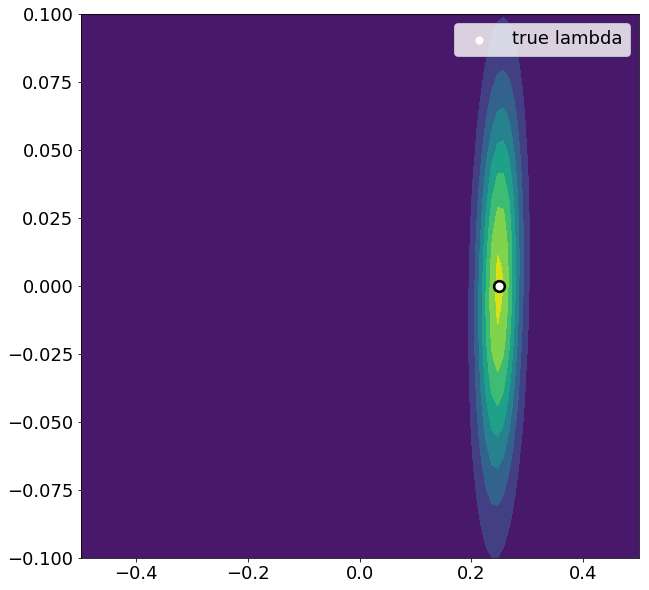

In [7]:
slice_obs_num = 1 # which observation do you want to condition on?
ns = 100

eval_L = np.linspace(-2*prior_std, 2*prior_std, ns) 
eval_E = np.linspace(-2*data_std, 2*data_std, ns)
# eval_L = np.linspace(0, prior_std, ns) 
# eval_E = np.linspace(-data_std/2, data_std/2, ns)

eval_pts = np.meshgrid(eval_L, eval_E)

eval_points = np.zeros((ns*ns, M+1))
eval_points[:,0] = eval_pts[0].ravel()
eval_points[:,slice_obs_num] = eval_pts[1].ravel()
# eval_points[:,1] = 0.01

L = eval_pts[0].reshape(ns,ns)
E = eval_pts[1].reshape(ns,ns)

    
post_eval = eval_updated(eval_points).reshape(ns,ns)

# eval_points
plt.figure(figsize=(10,10))
plt.contourf(L, E, post_eval, vmin=0, vmax=None)
# plt.vlines(obs_data[0],-.5, .5,alpha=0.5)
# plt.vlines(0,-.5, .5,alpha=0.5)

plt.scatter([lam],[noise[slice_obs_num-1]], color='black', s=150)
plt.scatter([lam],[noise[slice_obs_num-1]], color='white', s=50, label='true lambda')
# plt.scatter(accepted_inputs[:,0], accepted_inputs[:,1])
plt.legend()

# plt.scatter(o[:,0], o[:,1])
# plt.plot([-2*data_std+lam,2*data_std+lam], [-2*data_std,2*data_std], 'white', alpha=0.3)

# plt.axis('equal')
# plt.savefig('ZZtestpost.png')]

def conditionalY(x, fixy = 0):
    a = np.zeros((1,M+1))
    a[:,0] = x 
    a[:,1::] = fixy
    return eval_updated(a)[0]

def conditionalX(y, fixx = lam):
    a = np.zeros((1,M+1))
    a[:,0] = fixx
    a[:,1::] = y
    return eval_updated(a)[0]


I = quad(conditionalY, -1, 1, args=0)
# # I = quad(conditionalX, -2*data_std, 2*data_std, args=lam-1E-8)
# plt.hlines(noise[slice_obs_num-1], -prior_std + obs_data, prior_std + obs_data, label='data $\pm 0.05\sigma_\lambda$')

print('integral of conditional on noise:', I[0], 'error:', I[1])
plt.show()

## See differences in Pushforwards when you fix noise values

Exploring the "corners" of the M-dimensional Guassian hyper-sphere to get a sense of bounds on the noise sample space.

In [8]:
def see_difference(eps,idx):
    i0, i1 = idx
    input_samples_fix_noise = input_samples.copy()
    input_samples_fix_noise[:,i0:(i1+0)] = eps
    output_samps_fix_noise = model(input_samples_fix_noise)
    output_samples_fix_noise = loss_fun(output_samps_fix_noise)
    
    w = 3 # window size (to the left and right of zero)
    plt.figure(figsize=(20,10))
    plt.hist(output_samples, bins=40, density=True, color='b', alpha = 0.5, label='histogram of loss function for variable noise')
    plt.hist(output_samples_fix_noise, bins=40, density=True, alpha = 0.5, color='r', label='histogram of loss function for fixed noise')
    xmesh = np.linspace(-w, w, 1000)
    full_eval = sstats.gaussian_kde(output_samples).evaluate(xmesh)
    part_eval = sstats.gaussian_kde(output_samples_fix_noise).evaluate(xmesh)
    plt.plot(xmesh, full_eval, c='b', label='estimate of density for full problem', lw=3)
    plt.vlines(0,0, 0.3)
    plt.plot(xmesh, part_eval, c='r', label='estimate of density for approx problem', lw=3)
    plt.plot(xmesh, obs_dist.pdf(xmesh), 'k:', label='observed')
    plt.title('Data Space')
    plt.xlim([-w, w])
    plt.ylim([0, 0.1])
    plt.legend()
    plt.show()
    ratio_diff = np.abs( (full_eval - part_eval)/full_eval )
    print(ratio_diff.min(), ratio_diff.max())
    print(100*ratio_diff.mean(), ratio_diff.std())
    print(output_samples_fix_noise.min(), output_samples_fix_noise.max())
    print(output_samples.min(), output_samples.max())
    
eps_choice = list(np.linspace(-0.025, 0.025, 5))
wid.interact(see_difference, eps=wid.SelectionSlider(value=0, options=eps_choice, continuous_update=False),
             idx=wid.IntRangeSlider(value=(1,M+1), min=1, max=M+1, continuous_update=False),
            regularize=wid.Checkbox(value=True))


interactive(children=(SelectionSlider(continuous_update=False, description='eps', index=2, options=(-0.025, -0…

<function __main__.see_difference>

## Draw random samples from $\Xi$ and approximate push-forward

In [9]:
def see_variation(k,idx):
    i0, i1 = idx
    input_samples_fix_noise = input_samples.copy()
    input_samples_fix_noise[:,i0:i1] = input_samples_fix_noise[k,i0:i1]
    
    output_samps_fix_noise = model(input_samples_fix_noise)
    output_samples_fix_noise = loss_fun(output_samps_fix_noise)
    
    w = 5 # window size (to the left and right of zero)
    plt.figure(figsize=(20,10))
    plt.hist(output_samples, bins=40, density=True, color='b', alpha = 0.5, label='histogram of loss function for variable noise')
    plt.hist(output_samples_fix_noise, bins=40, density=True, alpha = 0.5, color='r', label='histogram of loss function for fixed noise')
    xmesh = np.linspace(-w, w, 1000)
    full_eval = sstats.gaussian_kde(output_samples).evaluate(xmesh)
    part_eval = sstats.gaussian_kde(output_samples_fix_noise).evaluate(xmesh)
    plt.plot(xmesh, full_eval, c='b', label='estimate of density for full problem', lw=3)
    plt.vlines(0,0, 0.3)
    plt.plot(xmesh, part_eval, c='r', label='estimate of density for approx problem', lw=3)
    plt.plot(xmesh, obs_dist.pdf(xmesh), 'k:', label='observed')
    plt.title('Data Space')
    plt.xlim([-w, w])
    plt.ylim([0, 0.1])
    plt.legend()
    plt.show()
    ratio_diff = np.abs( (full_eval - part_eval)/full_eval )
    print(ratio_diff.min(), ratio_diff.max())
    print(100*ratio_diff.mean(), ratio_diff.std())
    print(output_samples_fix_noise.min(), output_samples_fix_noise.max())
    print(output_samples.min(), output_samples.max())
    
wid.interact(see_variation, k=wid.IntSlider(value=0, min=0, max=N-1, continuous_update=False),
             idx=wid.IntRangeSlider(value=(1,M+1), min=1, max=M+1, continuous_update=False),
            regularize=wid.Checkbox(value=True))


interactive(children=(IntSlider(value=0, continuous_update=False, description='k', max=9999), IntRangeSlider(v…

<function __main__.see_variation>

## draw MC samples from $\Xi$ and plot their pushforwards

We get a sense of the variation in the pushforward approximation in the region of interest. 

_This represents experiments that COULD have happened_.
Notice that no individual draw from $\Xi$ can faithfully reproduce the full density. 

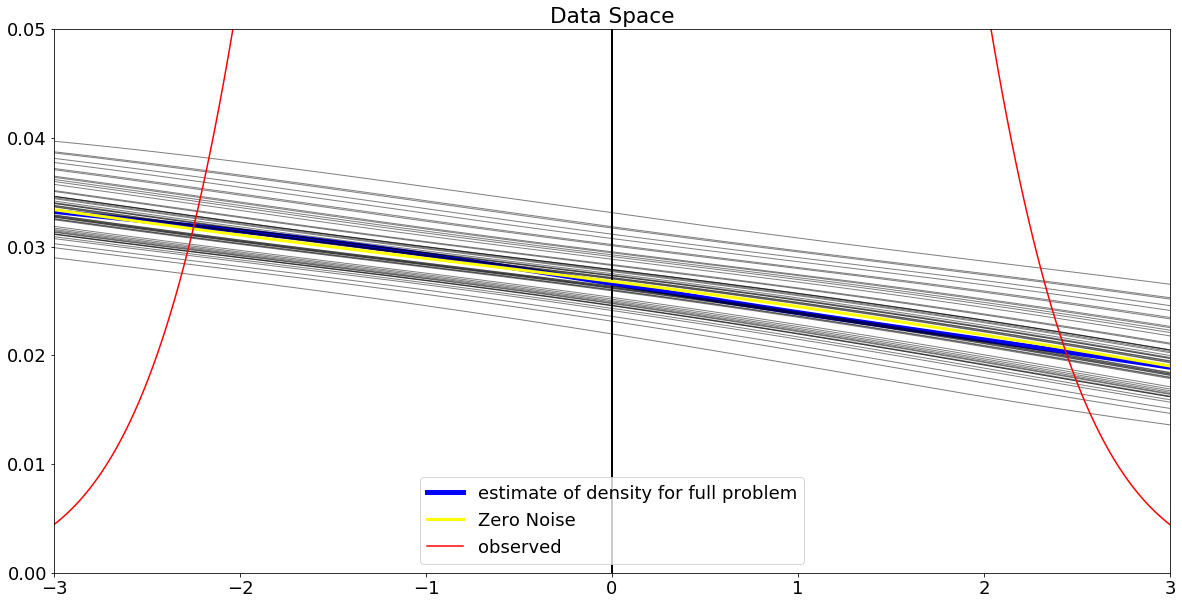

In [10]:
w = 3 # window size (to the left and right of zero)
xmesh = np.linspace(-w, w, 500)
plt.figure(figsize=(20,10))
# plt.hist(output_samples, bins=40, density=True, color='b', alpha = 0.5, label='histogram of loss function for variable noise')
full_eval = sstats.gaussian_kde(output_samples).evaluate(xmesh)
plt.plot(xmesh, full_eval, c='b', label='estimate of density for full problem', lw=5)

for k in range(50):
    input_samples_fix_noise = input_samples.copy()
    input_samples_fix_noise[:,1::] = input_samples_fix_noise[k,1::]
    output_samps_fix_noise = model(input_samples_fix_noise)
    output_samples_fix_noise = loss_fun(output_samps_fix_noise)
#     plt.hist(output_samples_fix_noise, bins=40, density=True, alpha = 0.5, color='r', label='histogram of loss function for fixed noise')
    part_eval = sstats.gaussian_kde(output_samples_fix_noise).evaluate(xmesh)
    plt.vlines(0,0, 1)
    plt.plot(xmesh, part_eval, c='k', lw=1, alpha=0.5)
    
input_samples_fix_noise = input_samples.copy()
input_samples_fix_noise[:,1::] = 0
output_samps_fix_noise = model(input_samples_fix_noise)
output_samples_fix_noise = loss_fun(output_samps_fix_noise)
#     plt.hist(output_samples_fix_noise, bins=40, density=True, alpha = 0.5, color='r', label='histogram of loss function for fixed noise')
part_eval = sstats.gaussian_kde(output_samples_fix_noise).evaluate(xmesh)
plt.plot(xmesh, part_eval, c='yellow', lw=3, alpha=1, label='Zero Noise')

plt.plot(xmesh, obs_dist.pdf(xmesh), 'r', label='observed')
plt.title('Data Space')
plt.xlim([-w, w])
plt.ylim([0, 0.05])
plt.legend()
# plt.savefig('no_one_line.png')
plt.show()


# Observed Noise

In [11]:
def noise_vary(eps, regularize=False):
    test_mesh = np.linspace(0,0.5,500)
    I = quad(conditionalY, -1, 1, args=eps)[0]
    test_eval = np.array([conditionalY(xi, fixy=eps) for xi in test_mesh])
    test_eval = test_eval/(1+regularize*(I-1))
    plt.figure(figsize=(20,10))
    # plt.plot(test_mesh, sstats.norm(scale=data_std).pdf(test_mesh))
#     plt.vlines(obs_data + noise, 0, 2, label='$d$')
#     plt.vlines(lam, 0, test_eval.max(), color='blue', label='$\lambda_0$')
    plt.plot(test_mesh, sstats.norm(loc=lam, scale=data_std).pdf(test_mesh), label='N(0,$\sigma_d$)')
    plt.plot(test_mesh, test_eval, c='r', label='conditional')
    plt.xlabel('$\lambda$')
#     if regularize:
#         plt.ylim([0,75])
#     else:
#         plt.ylim([0,1000])
    plt.legend()
    plt.show()
    return I 
    
def lam_vary(lam0, regularize=False):
    ww = 0.05
    test_mesh = np.linspace(-ww, ww, 500)
    I = quad(conditionalX, -ww, ww, args=lam0)[0]
    test_eval = np.array([conditionalX(xi, fixx=lam0) for xi in test_mesh])
    test_eval = test_eval/(1+regularize*(I-1))
    plt.figure(figsize=(20,10))
    plt.plot(test_mesh, sstats.norm(scale=data_std).pdf(test_mesh), label='N(0,$\sigma_d$)')
#     plt.vlines(noise, 0, test_eval.max(), label='noise')
#     plt.vlines(0, 0, test_eval.max(), color='blue', label='0')
    plt.plot(test_mesh, test_eval, c='r', label='conditional')
    plt.xlabel('$\epsilon$')
#     if regularize:
#         plt.ylim([0,75])
#     else:
#         plt.ylim([0,1000])
    plt.legend()
    plt.show()
    return I 


# Slice through a particular noise value.

In [12]:
eps_choice = list(np.linspace(-0.025, 0.025, 21)) 
wid.interact(noise_vary, eps=wid.SelectionSlider(value=0, options=eps_choice, continuous_update=False),
            regularize=wid.Checkbox(value=True))


interactive(children=(SelectionSlider(continuous_update=False, description='eps', index=10, options=(-0.025, -…

<function __main__.noise_vary>

# Slice through a particular input parameter value. (noise = 0)

In [13]:
lam_choice = list(np.linspace(0.2, 0.3, 21))
wid.interact(lam_vary, lam0=wid.SelectionSlider(value=lam, options=lam_choice, continuous_update=False),
            regularize=wid.Checkbox(value=True))


interactive(children=(SelectionSlider(continuous_update=False, description='lam0', index=10, options=(0.2, 0.2…

<function __main__.lam_vary>

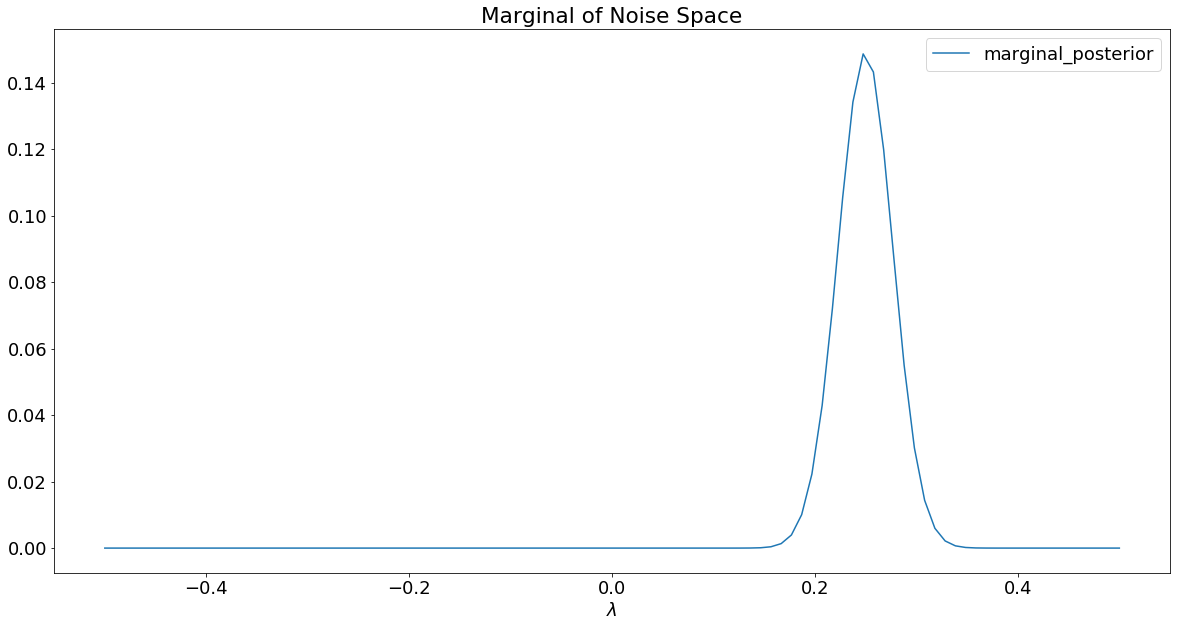

In [14]:
plt.figure(figsize=(20,10))
marg_L = np.sum(post_eval,axis=0)
marg_L = marg_L/np.sum(marg_L)
plt.plot(eval_L.ravel(), marg_L, label='marginal_posterior')
plt.xlabel('$\lambda$')
plt.title('Marginal of Noise Space')
# plt.vlines(obs_data,0,100,'r', label='obs data')
# plt.vlines(lam,0,100,'k', label='lam true')
# plt.ylim([0,1])
plt.legend()
plt.show()

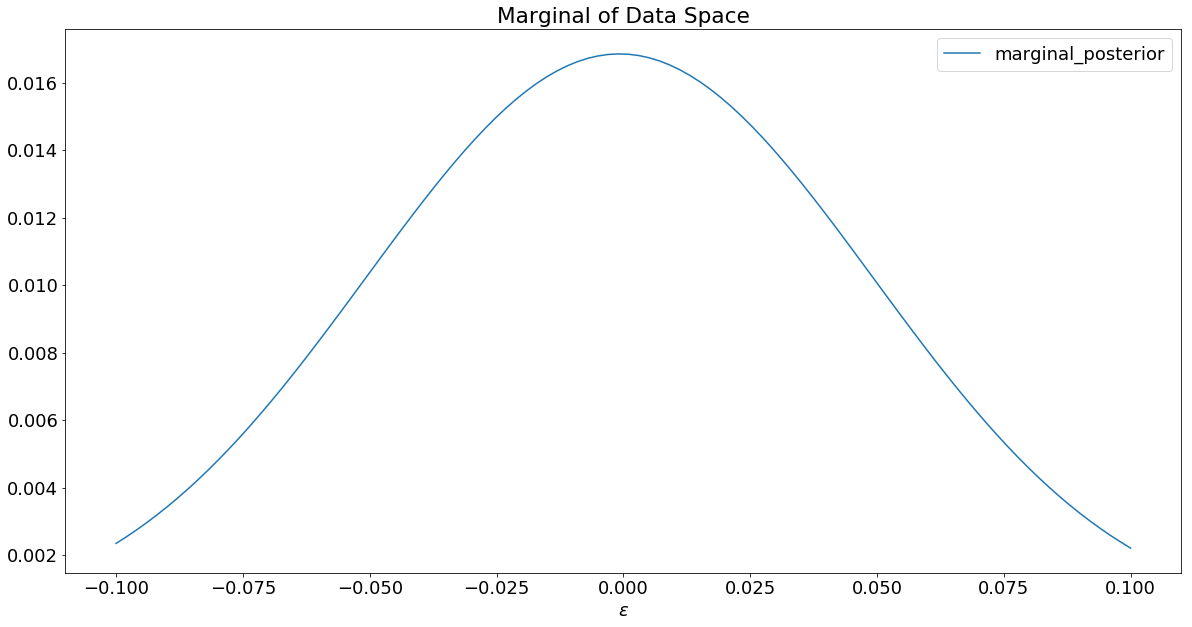

In [15]:
plt.figure(figsize=(20,10))
marg_E = np.sum(post_eval,axis=1)
marg_E = marg_E/np.sum(marg_E)
plt.plot(eval_E.ravel(), marg_E, label='marginal_posterior')
# plt.plot(eval_E, sstats.distributions.norm.pdf(eval_E, loc=0,scale=data_std))
plt.xlabel('$\epsilon$')
plt.title('Marginal of Data Space')
# plt.vlines(noise, 0, 200, 'r', label='noise')
# plt.vlines(0, 0, 200, label='mean zero')
plt.legend()
plt.show()